In [1]:
import h5py
import numpy as np
import PIL.Image as Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import PIL.Image as Image
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from transformers import  TFSegformerForSemanticSegmentation,SegformerFeatureExtractor
from PIL import Image
import requests
from IPython.display import clear_output
import os
import pandas as pd
from PIL import Image
import numpy as np
import tensorflow as tf

In [2]:


def load_h5_to_dictionary(file_path):
    data_dict = {}
    with h5py.File(file_path, 'r') as hf:
        for key in hf.keys():
            print(key)
            array_list = []
            group = hf[key]
            for dataset_name in group.keys():
                array_list.append(np.array(group[dataset_name]))
            data_dict[key] = array_list
    return data_dict

In [ ]:
!ls

In [ ]:
file_path = 'content/datasets/h5_out/raw_image_sim.h5'
loaded_dictionary_images_sim=load_h5_to_dictionary(file_path)

file_path = 'content/datasets/h5_out/semantic_id_list_sim.h5'
loaded_semantic_id_sim=load_h5_to_dictionary(file_path)

In [ ]:
weathers=["fog","morning","overcast","rain","sunset"]
loaded_dictionary_images_sim_weathers = {}
loaded_segmentation_masks_sim_weathers = {}
loaded_semantic_id_sim_weathers={}
for weather in weathers:
    file_path = f'content/datasets/h5_out/raw_image_sim_{weather}.h5'
    loaded_dictionary_images_sim_weathers[weather]=load_h5_to_dictionary(file_path)

    file_path = f'content/datasets/h5_out/semantic_id_list_sim_{weather}.h5'
    loaded_semantic_id_sim_weathers[weather]=load_h5_to_dictionary(file_path)

    file_path = f'content/datasets/h5_out/segmentation_masks_list_sim_{weather}.h5'
    loaded_segmentation_masks_sim_weathers[weather]=load_h5_to_dictionary(file_path)

In [6]:
desired_semantic_id = 0
def find_lowest_dimensions(images_list1, images_list2):
    lowest_height = min(images_list1[0].shape[0], images_list2[0].shape[0])
    lowest_width = min(images_list1[0].shape[1], images_list2[0].shape[1])
    return lowest_height, lowest_width

def crop_images_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width,:] for image in images_list]
    return cropped_images

def crop_1d_to_lowest_dimensions(images_list, lowest_height, lowest_width):
    cropped_images = [image[:lowest_height, :lowest_width] for image in images_list]
    return cropped_images

weather_index_list=list(loaded_dictionary_images_sim_weathers.keys())
test_index_list=["0020"]


lowest_height=374
lowest_width=1238 

print(weather_index_list)

for dataset_index in test_index_list:

    loaded_dictionary_images_sim[dataset_index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_sim[dataset_index], lowest_height, lowest_width)
    loaded_semantic_id_sim[dataset_index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_sim[dataset_index], lowest_height, lowest_width)

for dataset_index in weather_index_list:
        for index in test_index_list:
            loaded_semantic_id_sim_weathers[dataset_index][index] = crop_1d_to_lowest_dimensions(loaded_semantic_id_sim_weathers[dataset_index][index], lowest_height, lowest_width)
            loaded_dictionary_images_sim_weathers[dataset_index][index] = crop_images_to_lowest_dimensions(loaded_dictionary_images_sim_weathers[dataset_index][index], lowest_height, lowest_width)


['fog', 'morning', 'overcast', 'rain', 'sunset']


In [7]:
desired_semantic_id = 0
def map_to_r(number):
    colorr = [255, 128, 0, 0, 128, 0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 255, 128, 255, 0, 128]
    if number < 20:
        return int(colorr[number])
    else:
        return 0

def map_to_g(number):
    colorg = [0, 128, 255, 128, 0, 0, 128, 0, 0, 128, 0, 128, 0, 128, 255, 128, 0, 128, 255, 128]
    if number < 20:
        return int(colorg[number])
    else:
        return 0

def map_to_b(number):
    colorb = [0, 0, 0, 128, 128, 255, 255, 128, 0, 128, 128, 255, 128, 0, 0, 0, 128, 255, 255, 128]
    if number < 20:
        return int(colorb[number])
    else:
        return 255
    

dataset_index_list_train=["0001","0002","0006"]
dataset_index_list_test=["0020"]


In [8]:

test_indexes_sim = {}
test_indexes_weather = {}
indexes_real = {}
train_indexes_sim_perturbed = {}
valid_indexes_sim_perturbed = {}
pattern = 'tttttttttv'
pattern_pointer = 0


for dataset_index in dataset_index_list_test:
  test_dataset_inner = []
  for index in range(1, len(loaded_dictionary_images_sim[dataset_index])):
    test_dataset_inner.append(index)
  test_indexes_sim[dataset_index]=test_dataset_inner
  
for dataset_index in weather_index_list:
  test_dataset_inner={}
  for index in dataset_index_list_test:
    print(dataset_index,len(loaded_dictionary_images_sim_weathers[dataset_index][index]))
    test_dataset_inner[index] = []
    for index_inner in range(1, len(loaded_dictionary_images_sim_weathers[dataset_index][index])):
      test_dataset_inner[index].append(index_inner)
    test_indexes_weather[dataset_index]=test_dataset_inner


fog 837
morning 837
overcast 837
rain 837
sunset 837


In [9]:
print("Segmentation test sim") 
for dataset_index in dataset_index_list_test:
    print("Dataset", dataset_index)
    print("Test sim: ",len(test_indexes_sim[dataset_index]))
for dataset_index in weather_index_list:
    for index in dataset_index_list_test:
        print("Dataset", dataset_index, index)
        print("Test weather: ",len(test_indexes_weather[dataset_index][index]))

Segmentation test sim
Dataset 0020
Test sim:  836
Dataset fog 0020
Test weather:  836
Dataset morning 0020
Test weather:  836
Dataset overcast 0020
Test weather:  836
Dataset rain 0020
Test weather:  836
Dataset sunset 0020
Test weather:  836


In [10]:
import tensorflow as tf
import numpy as np

def map_to_desired_structure(input_image, output_image):
    return {'pixel_values': input_image, 'labels': output_image}
def map_to_desired_structure_weather(input_image, output_image, weather):
    return {'pixel_values': input_image, 'labels': output_image, 'weather': weather}

def map_values(value):
    # if value in [1, 2, 6, 7, 8, 16, 21, 255]:
    #     return 1
    # elif value in [11, 12]:
    #     return 2
    # elif value in [13, 14, 15, 17]:
    #     return 3
    # elif value == 10:
    #     return 4
    # elif value == 0:
    #     return 0
    # else:
    #     return 1
    # if value==255:
    #     value= 22
    return value

def generator(input_dict, output_dict, input_indices, input_dic_keys):
    vectorized_map = np.vectorize(map_values)
    for key in input_dic_keys:
        for index in input_indices[key]:
            if index < len(input_dict[key]):
                input_image = input_dict[key][index]
                output_image = output_dict[key][index]
                input_image = tf.reverse(input_image, axis=[-1])
                input_image = tf.transpose(input_image, (2, 0, 1))
                output_image = vectorized_map(output_image)
                yield input_image, output_image

def create_tf_dataset(input_dict, output_dict, input_indices, input_dic_keys, batch_size=5):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(input_dict, output_dict, input_indices, input_dic_keys),
        output_signature=(
            tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
            tf.TensorSpec(shape=(None, None), dtype=tf.float32)
        )
    )
    dataset = dataset.map(map_to_desired_structure)

    # Shuffle and batch the dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [11]:
def generator_weather(input_dict, output_dict, input_indices, input_dic_keys):
    vectorized_map = np.vectorize(map_values)
    for key in input_dic_keys:
        for key2 in input_indices[key]:
            for index in input_indices[key][key2]:
                if index < len(input_dict[key][key2]):
                    input_image = input_dict[key][key2][index]
                    output_image = output_dict[key][key2][index]
                    input_image = tf.reverse(input_image, axis=[-1])
                    input_image = tf.transpose(input_image, (2, 0, 1))
                    output_image = vectorized_map(output_image)
                    yield input_image, output_image, key

def create_tf_dataset_weather(input_dict, output_dict, input_indices, input_dic_keys, batch_size=5):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator_weather(input_dict, output_dict, input_indices, input_dic_keys),
        output_signature=(
            tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),  # Input image shape
            tf.TensorSpec(shape=(None, None), dtype=tf.float32),        # Output image shape
            tf.TensorSpec(shape=(), dtype=tf.string)                    # String data shape
        )
    )

    dataset = dataset.map(map_to_desired_structure_weather)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) 

    return dataset

In [12]:
tf_dataset_test_sim = create_tf_dataset(loaded_dictionary_images_sim, loaded_semantic_id_sim, test_indexes_sim,dataset_index_list_test)
tf_dataset_test_weather = create_tf_dataset_weather(loaded_dictionary_images_sim_weathers, loaded_semantic_id_sim_weathers, test_indexes_weather,weather_index_list)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-09-19 12:43:22.926948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-19 12:43:22.927501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
test_dataset =tf_dataset_test_sim
weather_dataset =tf_dataset_test_weather

In [14]:
auto = tf.data.AUTOTUNE


test_ds = (
    test_dataset
    .prefetch(auto)
)

weather_ds = (
    weather_dataset
    .prefetch(auto)
)

In [15]:
def calculate_mse(gt_mask, pred_mask):
    """Calculates the Mean Squared Error between the ground truth mask and predicted mask."""
    return np.mean((gt_mask - pred_mask) ** 2)
def calculate_iou(gt_mask, pred_mask, num_classes):
    """Calculates Intersection over Union (IoU) for each class."""
    iou_per_class = []
    for class_id in range(num_classes):
        gt_class_mask = (gt_mask == class_id)
        pred_class_mask = (pred_mask == class_id)
        intersection = np.logical_and(gt_class_mask, pred_class_mask).sum()
        union = np.logical_or(gt_class_mask, pred_class_mask).sum()

        if union == 0:
            iou = 1.0  # If there are no ground truth or predicted pixels, IoU is perfect
        else:
            iou = intersection / union
        
        iou_per_class.append(iou)

    return iou_per_class
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-7)
def calculate_accuracy(gt, pred):
    correct_predictions = tf.reduce_sum(tf.cast(tf.equal(gt, pred), dtype=tf.float32))
    total_pixels = tf.cast(tf.size(gt), dtype=tf.float32)
    return correct_predictions / total_pixels
def calculate_recall(gt, pred):
    gt = tf.cast(gt, tf.float32)
    pred = tf.cast(pred, tf.float32)
    
    true_positive = tf.reduce_sum(gt * pred)
    false_negative = tf.reduce_sum(gt) - true_positive
    return true_positive / (true_positive + false_negative + 1e-7)
def calculate_precision(gt, pred):
    gt = tf.cast(gt, tf.float32)
    pred = tf.cast(pred, tf.float32)
    
    true_positive = tf.reduce_sum(gt * pred)
    false_positive = tf.reduce_sum(pred) - true_positive
    return true_positive / (true_positive + false_positive + 1e-7)
def calculate_dice(gt, pred):
    gt = tf.cast(gt, tf.float32)
    pred = tf.cast(pred, tf.float32)
    intersection = tf.reduce_sum(gt * pred)
    return (2. * intersection) / (tf.reduce_sum(gt) + tf.reduce_sum(pred) + 1e-7)

In [16]:
def calculate_f1_per_class(precision, recall, num_classes):
    f1_per_class = []
    for class_id in range(num_classes):
        f1 = 2 * (precision[class_id] * recall[class_id]) / (precision[class_id] + recall[class_id] + 1e-7)
        f1_per_class.append(f1)
    return f1_per_class
def calculate_accuracy_per_class(gt_mask, pred_mask, num_classes):
    accuracy_per_class = []
    for class_id in range(num_classes):
        gt_class_mask = (gt_mask == class_id)
        pred_class_mask = (pred_mask == class_id)
        
        correct_predictions = tf.reduce_sum(tf.cast(tf.equal(gt_class_mask, pred_class_mask), dtype=tf.float32))
        total_pixels = tf.reduce_sum(tf.cast(gt_class_mask, tf.float32))
        
        if total_pixels == 0:
            accuracy_per_class.append(1.0)  # If no pixels of this class, assume perfect accuracy
        else:
            accuracy_per_class.append(correct_predictions / total_pixels)
    
    return accuracy_per_class
def calculate_recall_per_class(gt_mask, pred_mask, num_classes):
    recall_per_class = []
    for class_id in range(num_classes):
        gt_class_mask = tf.cast(gt_mask == class_id, tf.float32)
        pred_class_mask = tf.cast(pred_mask == class_id, tf.float32)
        
        true_positive = tf.reduce_sum(gt_class_mask * pred_class_mask)
        false_negative = tf.reduce_sum(gt_class_mask) - true_positive
        
        if (true_positive + false_negative) == 0:
            recall_per_class.append(1.0)
        else:
            recall_per_class.append(true_positive / (true_positive + false_negative + 1e-7))
    
    return recall_per_class
def calculate_precision_per_class(gt_mask, pred_mask, num_classes):
    precision_per_class = []
    for class_id in range(num_classes):
        gt_class_mask = tf.cast(gt_mask == class_id, tf.float32)
        pred_class_mask = tf.cast(pred_mask == class_id, tf.float32)
        
        true_positive = tf.reduce_sum(gt_class_mask * pred_class_mask)
        false_positive = tf.reduce_sum(pred_class_mask) - true_positive
        
        if (true_positive + false_positive) == 0:
            precision_per_class.append(1.0)
        else:
            precision_per_class.append(true_positive / (true_positive + false_positive + 1e-7))
    
    return precision_per_class
def calculate_dice_per_class(gt_mask, pred_mask, num_classes):
    dice_per_class = []
    for class_id in range(num_classes):
        gt_class_mask = tf.cast(gt_mask == class_id, tf.float32)
        pred_class_mask = tf.cast(pred_mask == class_id, tf.float32)
        
        intersection = tf.reduce_sum(gt_class_mask * pred_class_mask)
        dice_score = (2. * intersection) / (tf.reduce_sum(gt_class_mask) + tf.reduce_sum(pred_class_mask) + 1e-7)
        
        dice_per_class.append(dice_score)
    
    return dice_per_class

In [17]:
def display(display_list,label="output plots"):
    plt.figure(figsize=(15, 15))
    print(label)
    title = ["Input Image", "True Mask", "Predicted Mask","diff"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        img=tf.keras.utils.array_to_img(display_list[i])
        img_raw=display_list[i].numpy().astype(int)[:,:,0]
        if i>0:
            print(np.unique(img_raw))
            colored_mask = np.zeros_like(tf.keras.utils.array_to_img(display_list[0]))
            colored_mask[:, :, 0] = np.vectorize(map_to_b)(img_raw)
            colored_mask[:, :, 1] = np.vectorize(map_to_g)(img_raw)
            colored_mask[:, :, 2] = np.vectorize(map_to_r)(img_raw)
            img=colored_mask
        plt.imshow(img)
        plt.axis("off")
    plt.show()

weathers


2024-09-19 12:43:23.207163: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


fog
output plots
[ 0  1  2  7  8 10 13 21]


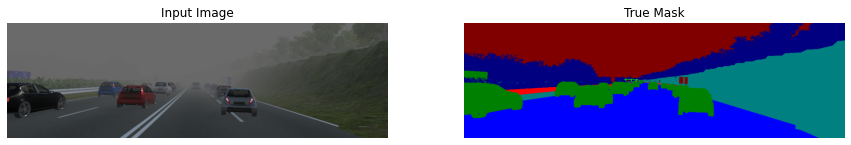

fog
output plots
[ 0  1  2  7  8 10 13 21]


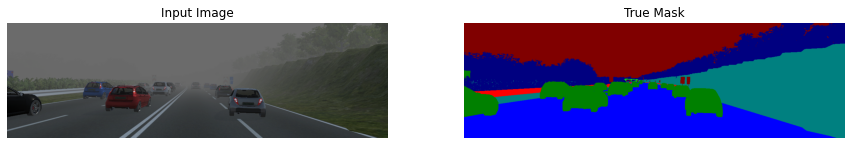

fog
output plots
[ 0  1  2  7  8 10 13 21]


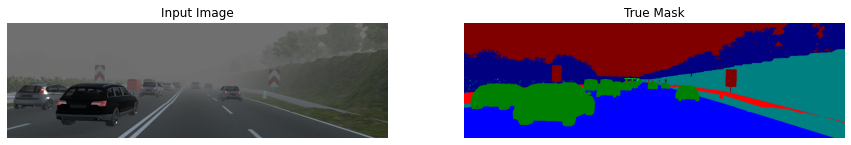

fog
output plots
[ 0  1  2  7  8 10 13 21]


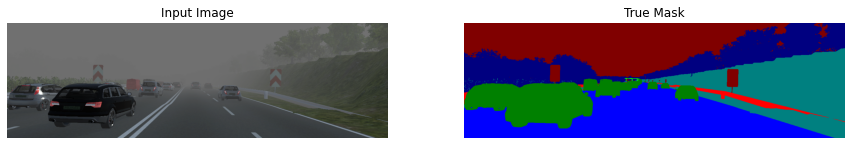

fog
output plots
[ 0  1  2  7  8 10 13 21]


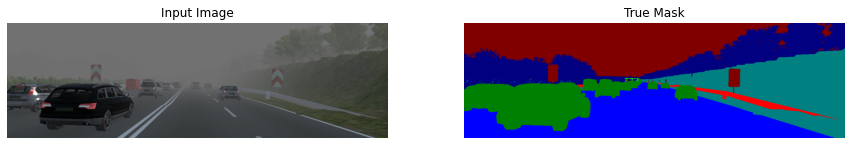

In [22]:
print("weathers")
for samples in weather_ds.take(1):
    for i in range(0,5):
        sample_image, sample_mask, weather = samples["pixel_values"][i], samples["labels"][i], samples["weather"][i]
        sample_image = tf.transpose(sample_image, (1, 2, 0))
        
        sample_mask = tf.expand_dims(sample_mask, -1)
        print(weather.numpy().decode('utf-8'))
        display([sample_image, sample_mask])

In [ ]:
model_checkpoint = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"

# id2label mapping for the KITTI dataset
label2id = {
        'Road': 0,
        'Sidewalk': 1,
        'Building': 2,
        'Wall': 3,
        'Fence': 4,
        'Pole': 5,
        'TrafficLight': 6,
        'TrafficSign': 7,
        'Vegetation': 8,
        'Terrain': 9,
        'Sky': 10,
        'Person': 11,
        'Rider': 12,
        'Car': 13,
        'Truck': 14,
        'Bus': 15,
        'Train': 16,
        'Motorcycle': 17,
        'Bicycle': 18,
        'Void': 255,
        'Misc': 19,
        'GuardRail': 20,
    }
id2label = {label: id for id, label in label2id.items()}
num_labels = len(id2label)
print(len(id2label))
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask
    
def cast_to_int32(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.cast(image * 255, tf.int32)
    return image
    

def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            
            images, masks = sample["pixel_values"], sample["labels"]
            print(images.shape)
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            created_masks=cast_to_int32(create_mask(pred_masks))
            for i in range(0,len(created_masks)):
                gt=cast_to_int32(masks[i])
                created_mask=created_masks[i]
                created_mask = tf.image.resize(created_mask, [374, 1238],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                diff_mask_road=abs(created_mask-gt)
                print(f"MSE: {calculate_mse(gt, created_mask)}")
                print(f"IOU: {calculate_iou(gt, created_mask,22)}")
                display([images[i], gt,created_mask,diff_mask_road ])

def show_predictions_weather(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            
            images, masks, weather = sample["pixel_values"], sample["labels"], sample["weather"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            created_masks=cast_to_int32(create_mask(pred_masks))
            for i in range(0,len(created_masks)):
                gt=cast_to_int32(masks[i])
                created_mask=created_masks[i]
                created_mask = tf.image.resize(created_mask, [374, 1238],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                weather_sample=weather[i].numpy().decode('utf-8')
                diff_mask_road=abs(created_mask-gt)
                print(f"MSE: {calculate_mse(gt, created_mask)}")
                print(f"IOU: {calculate_iou(gt, created_mask,22)}")
                display([images[i], gt,created_mask,diff_mask_road ],weather_sample)


def calculate_tp_fp_tn_fn(gt_flat, pred_flat, num_classes):
    TP = np.zeros(num_classes)
    FP = np.zeros(num_classes)
    TN = np.zeros(num_classes)
    FN = np.zeros(num_classes)

    for class_idx in range(num_classes):
        gt_class = (gt_flat == class_idx)
        pred_class = (pred_flat == class_idx)
        
        TP[class_idx] += np.sum(np.logical_and(gt_class, pred_class))
        FP[class_idx] += np.sum(np.logical_and(~gt_class, pred_class))
        FN[class_idx] += np.sum(np.logical_and(gt_class, ~pred_class))
        TN[class_idx] += np.sum(np.logical_and(~gt_class, ~pred_class))
        
    return TP, FP, TN, FN

class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [25]:
def calculate_psnr(gt, pred, epsilon=1e-7):
    mse = np.mean((gt - pred) ** 2)
    if mse == 0:
        return np.inf
    max_pixel = np.max(gt)
    psnr = 20 * np.log10(max_pixel / (np.sqrt(mse) + epsilon))
    return psnr

def calculate_mae(gt, pred):
    return tf.reduce_mean(tf.abs(tf.cast(gt, tf.float32) - tf.cast(pred, tf.float32))).numpy()

def calculate_ssim(gt, pred):
    gt_img = gt.numpy().squeeze()
    pred_img = pred.numpy().squeeze()
    
    if gt_img.size == 0 or pred_img.size == 0:
        return 0 
    
    if gt_img.ndim < 2 or pred_img.ndim < 2:
        raise ValueError("Images must have at least two dimensions")
    
    min_dim = min(gt_img.shape[0], gt_img.shape[1])
    
    win_size = min(7, min_dim)
    if win_size % 2 == 0:
        win_size = max(win_size - 1, 1)  # Ensure win_size is at least 1
    
    if gt_img.ndim == 3:
        channel_axis = -1 
    else:
        channel_axis = None 
    
    ssim_value = ssim(
        gt_img,
        pred_img,
        data_range=gt_img.max() - gt_img.min(),
        win_size=win_size,
        channel_axis=channel_axis
    )
    return ssim_value

In [26]:
def show_metrics_extended(dataset=None, num_classes=22, model=None, output_dir='metrics_logs', diff_images_dir='segmentation_differences'):
    epsilon = 1e-7 

    if dataset:
        total_samples = 0

        TP_total = np.zeros(num_classes)
        FP_total = np.zeros(num_classes)
        TN_total = np.zeros(num_classes)
        FN_total = np.zeros(num_classes)
        total_mse = 0
        total_mae = 0
        total_ssim = 0
        total_pixel_accuracy = 0
        total_psnr = 0

        total_pixels_considered = 0 

        per_class_metrics = []

        if not os.path.exists(diff_images_dir):
            os.makedirs(diff_images_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        sample_index = 0  

        for batch in dataset:
            
            images, masks = batch["pixel_values"], batch["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_logits = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            pred_masks = create_mask(pred_logits)  

            gt = cast_to_int32(masks)
            pred = cast_to_int32(pred_masks)

            pred = tf.image.resize(pred, [374, 1238], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            gt = tf.image.resize(gt, [374, 1238], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            gt_flat = tf.reshape(gt, [-1]).numpy()
            pred_flat = tf.reshape(pred, [-1]).numpy()

            valid_mask = gt_flat != 255
            gt_filtered = gt_flat[valid_mask]
            pred_filtered = pred_flat[valid_mask]

            

            mse_value = np.mean((gt_filtered - pred_filtered) ** 2)
            total_mse += mse_value * len(gt_filtered)
            mae_value = np.mean(np.abs(gt_filtered - pred_filtered))
            total_mae += mae_value * len(gt_filtered)

            total_pixels_considered += len(gt_filtered)

            difference = np.abs(gt_filtered - pred_filtered)
            difference_image = np.zeros_like(gt_flat)
            difference_image[valid_mask] = difference
            difference_image = difference_image.reshape(gt.shape[0], gt.shape[1], gt.shape[2])
            difference_image = difference_image.astype(np.uint8) * (255 // num_classes)

            for i in range(difference_image.shape[0]):
                image_path = os.path.join(diff_images_dir, f'difference_{sample_index}.png')
                Image.fromarray(difference_image[i].squeeze(), mode='L').save(image_path)
                sample_index += 1

            TP, FP, TN, FN = calculate_tp_fp_tn_fn(gt_filtered, pred_filtered, num_classes)
            TP_total += TP
            FP_total += FP
            TN_total += TN
            FN_total += FN

            correct_pixels = np.sum(gt_filtered == pred_filtered)
            pixel_accuracy = correct_pixels / (len(gt_filtered) + epsilon)
            total_pixel_accuracy += pixel_accuracy * len(gt_filtered)

            total_samples += gt.shape[0]

            if total_samples % 100 == 0:
                print(f"Processed {total_samples} samples")

        precision = TP_total / (TP_total + FP_total + epsilon)
        recall = TP_total / (TP_total + FN_total + epsilon)
        f1_score = 2 * precision * recall / (precision + recall + epsilon)
        accuracy = (TP_total + TN_total) / (TP_total + FP_total + TN_total + FN_total + epsilon)
        iou = TP_total / (TP_total + FP_total + FN_total + epsilon)
        dice = 2 * TP_total / (2 * TP_total + FP_total + FN_total + epsilon)
        specificity = TN_total / (TN_total + FP_total + epsilon)

        avg_mse = total_mse / (total_pixels_considered + epsilon)
        avg_mae = total_mae / (total_pixels_considered + epsilon)
        avg_pixel_accuracy = total_pixel_accuracy / (total_pixels_considered + epsilon)

        for class_idx in range(num_classes):
            per_class_metrics.append({
                'Class': class_idx,
                'Precision': precision[class_idx],
                'Recall': recall[class_idx],
                'F1 Score': f1_score[class_idx],
                'Specificity': specificity[class_idx],
                'Accuracy': accuracy[class_idx],
                'IoU': iou[class_idx],
                'Dice Coefficient': dice[class_idx]
            })

        per_class_metrics_df = pd.DataFrame(per_class_metrics)

        relevant_TP = TP_total.sum()
        relevant_FP = FP_total.sum()
        relevant_TN = TN_total.sum()
        relevant_FN = FN_total.sum()

        overall_precision = relevant_TP / (relevant_TP + relevant_FP + epsilon)
        overall_recall = relevant_TP / (relevant_TP + relevant_FN + epsilon)
        overall_specificity = relevant_TN / (relevant_TN + relevant_FP + epsilon)
        overall_accuracy = (relevant_TP + relevant_TN) / (relevant_TP + relevant_FP + relevant_FN + relevant_TN + epsilon)
        overall_f1_score = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + epsilon)
        overall_iou = relevant_TP / (relevant_TP + relevant_FP + relevant_FN + epsilon)
        overall_dice = 2 * relevant_TP / (2 * relevant_TP + relevant_FP + relevant_FN + epsilon)
        overall_mcc = ((relevant_TP * relevant_TN) - (relevant_FP * relevant_FN)) / \
                      (np.sqrt((relevant_TP + relevant_FP) * (relevant_TP + relevant_FN) * (relevant_TN + relevant_FP) * (relevant_TN + relevant_FN)) + epsilon)

        mean_iou = iou.mean()
        mean_precision = precision.mean()
        mean_recall = recall.mean()
        mean_f1_score = f1_score.mean()

        class_frequencies = (TP_total + FN_total) / (TP_total.sum() + FN_total.sum() + epsilon)
        frequency_weighted_iou = np.sum(class_frequencies * iou)

        balanced_accuracy = (overall_recall + overall_specificity) / 2

        overall_metrics = {
            'Average MSE': avg_mse,
            'Average MAE': avg_mae,
            'Average Pixel Accuracy': avg_pixel_accuracy,
            'Overall Precision': overall_precision,
            'Overall Recall': overall_recall,
            'Overall Specificity': overall_specificity,
            'Overall F1 Score': overall_f1_score,
            'Overall Accuracy': overall_accuracy,
            'Overall IoU': overall_iou,
            'Overall Dice Coefficient': overall_dice,
            'Overall MCC': overall_mcc,
            'Mean IoU': mean_iou,
            'Mean Precision': mean_precision,
            'Mean Recall': mean_recall,
            'Mean F1 Score': mean_f1_score,
            'Frequency Weighted IoU': frequency_weighted_iou,
            'Balanced Accuracy': balanced_accuracy
        }

        overall_metrics_df = pd.DataFrame(list(overall_metrics.items()), columns=['Metric', 'Value'])

        per_class_metrics_df.to_csv(os.path.join(output_dir, 'per_class_metrics.csv'), index=False)
        overall_metrics_df.to_csv(os.path.join(output_dir, 'overall_metrics.csv'), index=False)

        print("Per Class Metrics:")
        print(per_class_metrics_df)
        print("\nOverall Metrics:")
        print(overall_metrics_df)

In [28]:
def show_metrics_extended_weather(dataset=None, num_classes=22, model=None, output_dir='metrics_logs', diff_images_dir='segmentation_differences', has_weather=False):
    import os
    import pandas as pd
    from PIL import Image
    import numpy as np
    import tensorflow as tf

    epsilon = 1e-7  # Assign at the beginning

    if dataset:
        total_samples = 0

        # Initialize accumulators per weather type
        weather_metrics = {}

        # Create directories if they don't exist
        if not os.path.exists(diff_images_dir):
            os.makedirs(diff_images_dir)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        sample_index = 0  # To name the saved images uniquely

        for batch in dataset:
            if has_weather:
                images, masks, weather = batch["pixel_values"], batch["labels"], batch["weather"]
                unique_weathers = np.unique(weather)

                for w in unique_weathers:
                    # Filter images and masks by the current weather type
                    mask_for_weather = weather == w
                    images_weather = images[mask_for_weather]
                    masks_weather = masks[mask_for_weather]

                    if w not in weather_metrics:
                        weather_metrics[w] = {
                            'TP_total': np.zeros(num_classes),
                            'FP_total': np.zeros(num_classes),
                            'TN_total': np.zeros(num_classes),
                            'FN_total': np.zeros(num_classes),
                            'total_mse': 0,
                            'total_mae': 0,
                            'total_pixel_accuracy': 0,
                            'total_pixels_considered': 0,
                            'per_class_metrics': {class_idx: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0} for class_idx in range(num_classes)}
                        }

                    # Process the batch for this specific weather
                    masks_weather = tf.expand_dims(masks_weather, -1)
                    pred_logits = model.predict(images_weather).logits
                    images_weather = tf.transpose(images_weather, (0, 2, 3, 1))
                    pred_masks = create_mask(pred_logits)

                    gt = cast_to_int32(masks_weather)
                    pred = cast_to_int32(pred_masks)

                    pred = tf.image.resize(pred, [374, 1238], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                    gt = tf.image.resize(gt, [374, 1238], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

                    gt_flat = tf.reshape(gt, [-1]).numpy()
                    pred_flat = tf.reshape(pred, [-1]).numpy()

                    valid_mask = gt_flat != 255
                    gt_filtered = gt_flat[valid_mask]
                    pred_filtered = pred_flat[valid_mask]

                    mse_value = np.mean((gt_filtered - pred_filtered) ** 2)
                    mae_value = np.mean(np.abs(gt_filtered - pred_filtered))

                    weather_metrics[w]['total_mse'] += mse_value * len(gt_filtered)
                    weather_metrics[w]['total_mae'] += mae_value * len(gt_filtered)
                    weather_metrics[w]['total_pixels_considered'] += len(gt_filtered)

                    TP, FP, TN, FN = calculate_tp_fp_tn_fn(gt_filtered, pred_filtered, num_classes)
                    weather_metrics[w]['TP_total'] += TP
                    weather_metrics[w]['FP_total'] += FP
                    weather_metrics[w]['TN_total'] += TN
                    weather_metrics[w]['FN_total'] += FN

                    correct_pixels = np.sum(gt_filtered == pred_filtered)
                    pixel_accuracy = correct_pixels / (len(gt_filtered) + epsilon)
                    weather_metrics[w]['total_pixel_accuracy'] += pixel_accuracy * len(gt_filtered)

                    # Accumulate per-class metrics
                    for class_idx in range(num_classes):
                        weather_metrics[w]['per_class_metrics'][class_idx]['TP'] += TP[class_idx]
                        weather_metrics[w]['per_class_metrics'][class_idx]['FP'] += FP[class_idx]
                        weather_metrics[w]['per_class_metrics'][class_idx]['FN'] += FN[class_idx]
                        weather_metrics[w]['per_class_metrics'][class_idx]['TN'] += TN[class_idx]

                    # Save difference images (for valid pixels)
                    difference = np.abs(gt_filtered - pred_filtered)
                    difference_image = np.zeros_like(gt_flat)
                    difference_image[valid_mask] = difference
                    difference_image = difference_image.reshape(gt.shape[0], gt.shape[1], gt.shape[2])
                    difference_image = difference_image.astype(np.uint8) * (255 // num_classes)
                    char = "'"
                    weather_string = str(w).split(char)[1]
                    if not os.path.exists(os.path.join(diff_images_dir, weather_string)):
                        os.makedirs(os.path.join(diff_images_dir, weather_string))
                    for i in range(difference_image.shape[0]):
                        image_path = os.path.join(diff_images_dir, f'{weather_string}/{sample_index}.png')
                        Image.fromarray(difference_image[i].squeeze(), mode='L').save(image_path)
                        sample_index += 1

                    total_samples += gt.shape[0]

                    if total_samples % 100 == 0:
                        print(f"Processed {total_samples} samples")

        # After processing the batches, calculate metrics for each weather type
        overall_weather_metrics = {}
        per_class_weather_metrics = {}

        for w, metrics in weather_metrics.items():
            TP_total = metrics['TP_total']
            FP_total = metrics['FP_total']
            TN_total = metrics['TN_total']
            FN_total = metrics['FN_total']

            precision = TP_total / (TP_total + FP_total + epsilon)
            recall = TP_total / (TP_total + FN_total + epsilon)
            f1_score = 2 * precision * recall / (precision + recall + epsilon)
            accuracy = (TP_total + TN_total) / (TP_total + FP_total + TN_total + FN_total + epsilon)
            iou = TP_total / (TP_total + FP_total + FN_total + epsilon)
            dice = 2 * TP_total / (2 * TP_total + FP_total + FN_total + epsilon)
            specificity = TN_total / (TN_total + FP_total + epsilon)

            avg_mse = metrics['total_mse'] / (metrics['total_pixels_considered'] + epsilon)
            avg_mae = metrics['total_mae'] / (metrics['total_pixels_considered'] + epsilon)
            avg_pixel_accuracy = metrics['total_pixel_accuracy'] / (metrics['total_pixels_considered'] + epsilon)

            relevant_TP = TP_total.sum()
            relevant_FP = FP_total.sum()
            relevant_TN = TN_total.sum()
            relevant_FN = FN_total.sum()

            overall_precision = relevant_TP / (relevant_TP + relevant_FP + epsilon)
            overall_recall = relevant_TP / (relevant_TP + relevant_FN + epsilon)
            overall_specificity = relevant_TN / (relevant_TN + relevant_FP + epsilon)
            overall_accuracy = (relevant_TP + relevant_TN) / (relevant_TP + relevant_FP + relevant_FN + relevant_TN + epsilon)
            overall_f1_score = 2 * overall_precision * overall_recall / (overall_precision + overall_recall + epsilon)
            overall_iou = relevant_TP / (relevant_TP + relevant_FP + relevant_FN + epsilon)
            overall_dice = 2 * relevant_TP / (2 * relevant_TP + relevant_FP + relevant_FN + epsilon)

            # Store overall metrics for weather
            overall_weather_metrics[w] = {
                'Weather Type': w,
                'Average MSE': avg_mse,
                'Average MAE': avg_mae,
                'Average Pixel Accuracy': avg_pixel_accuracy,
                'Overall Precision': overall_precision,
                'Overall Recall': overall_recall,
                'Overall Specificity': overall_specificity,
                'Overall F1 Score': overall_f1_score,
                'Overall Accuracy': overall_accuracy,
                'Overall IoU': overall_iou,
                'Overall Dice Coefficient': overall_dice,
            }

            # Calculate per-class metrics for each weather type
            per_class_metrics = []
            for class_idx in range(num_classes):
                per_class_TP = metrics['per_class_metrics'][class_idx]['TP']
                per_class_FP = metrics['per_class_metrics'][class_idx]['FP']
                per_class_FN = metrics['per_class_metrics'][class_idx]['FN']
                per_class_TN = metrics['per_class_metrics'][class_idx]['TN']

                precision_class = per_class_TP / (per_class_TP + per_class_FP + epsilon)
                recall_class = per_class_TP / (per_class_TP + per_class_FN + epsilon)
                f1_class = 2 * precision_class * recall_class / (precision_class + recall_class + epsilon)
                iou_class = per_class_TP / (per_class_TP + per_class_FP + per_class_FN + epsilon)
                dice_class = 2 * per_class_TP / (2 * per_class_TP + per_class_FP + per_class_FN + epsilon)

                per_class_metrics.append({
                    'Class': class_idx,
                    'Precision': precision_class,
                    'Recall': recall_class,
                    'F1 Score': f1_class,
                    'IoU': iou_class,
                    'Dice Coefficient': dice_class
                })

            # Store per-class metrics for this weather type
            per_class_weather_metrics[w] = pd.DataFrame(per_class_metrics)

        # Convert to DataFrame and save to CSV
        overall_weather_metrics_df = pd.DataFrame(overall_weather_metrics).T
        overall_weather_metrics_df.to_csv(os.path.join(output_dir, 'overall_weather_metrics.csv'), index=False)

        for w, per_class_df in per_class_weather_metrics.items():
            weather_string = str(w).split("'")[1]  # Extract weather string for naming
            per_class_df.to_csv(os.path.join(output_dir, f'per_class_metrics_{weather_string}.csv'), index=False)

        print("\nOverall Metrics by Weather Type:")
        print(overall_weather_metrics_df)

# ORIGINAL MODEL EVALUATION

In [29]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

In [30]:
checkpoint_file_path = "./content/Model_original.hdf5"
model.load_weights(checkpoint_file_path)

2024-09-19 12:43:49.328568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


MSE: 21.380795746114572
IOU: [0.7882591787715887, 0.15908136662337788, 0.0009927002302037604, 1.0, 1.0, 1.0, 1.0, 0.0, 0.16840396782250378, 1.0, 0.5334525125647841, 1.0, 1.0, 0.8056410456192294, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  8 10 13]
[ 0  1  2  5  6  7  8  9 11 12 13 19 20 21]


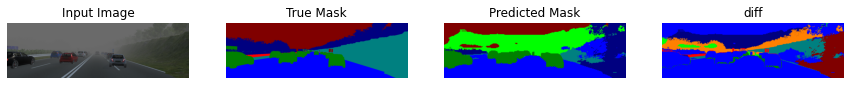

MSE: 18.856871960121985
IOU: [0.776741558142617, 0.17769886644641833, 0.0013277360148394024, 1.0, 1.0, 1.0, 1.0, 0.0, 0.17291282846892272, 1.0, 0.603249239153776, 1.0, 1.0, 0.8220802318687833, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  8 10 13]
[ 0  1  2  3  5  6  7  8  9 11 12 13 19 20 21]


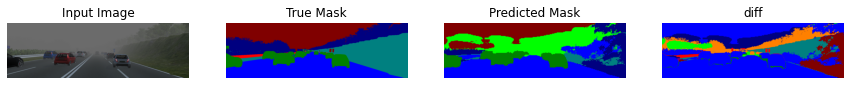

MSE: 16.734888080654496
IOU: [0.8198336164883986, 0.22933169941791764, 0.002344515964022337, 1.0, 1.0, 1.0, 1.0, 0.6307810401074649, 0.17847016128365586, 1.0, 0.7729330136072762, 1.0, 1.0, 0.8089978176934699, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 11 12 13 14 19 20 21]


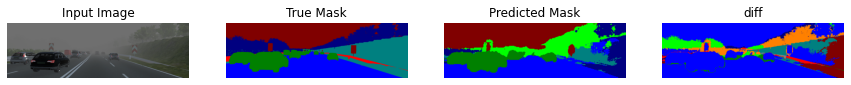

MSE: 19.345472687532936
IOU: [0.7826138267991597, 0.19940528441011235, 0.001814696775510667, 1.0, 1.0, 1.0, 1.0, 0.6678095238095239, 0.17509093189514613, 1.0, 0.6988794063079777, 1.0, 1.0, 0.8135843939720793, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13]
[ 0  1  2  5  6  7  8  9 11 12 13 14 19 20 21]


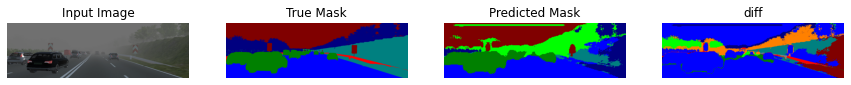

MSE: 21.397035066045806
IOU: [0.8027236996920818, 0.19318131795571597, 0.001565971440595852, 1.0, 1.0, 1.0, 1.0, 0.6437135450421257, 0.16392265010899001, 1.0, 0.6257506803919658, 1.0, 1.0, 0.824534274752367, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 11 12 13 14 19 20 21]


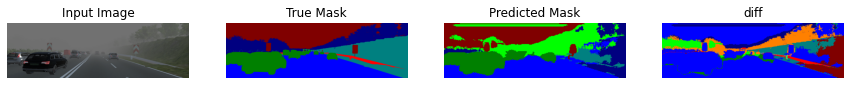

In [31]:
show_predictions_weather(dataset=weather_ds)

In [ ]:
show_metrics_extended(test_ds,num_classes=22, model=model, output_dir='./content/evaluation/model_original', diff_images_dir='./content/evaluation/model_original_segmentations')

In [ ]:
show_metrics_extended_weather(weather_ds,num_classes=22, model=model, output_dir='./content/evaluation/model_original_weather', diff_images_dir='./content/evaluation/model_original_weather_segmentations',has_weather=True)

# EXTENDED MODEL EVALUATION

In [34]:
checkpoint_file_path = "./content/Model_original_perturbed.hdf5"
model.load_weights(checkpoint_file_path)

MSE: 9.063985382668267
IOU: [0.9368920910430654, 0.4668493582792816, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.3231772680046836, 1.0, 0.7232022522387612, 1.0, 1.0, 0.8736284685447998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  2  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 20 21]


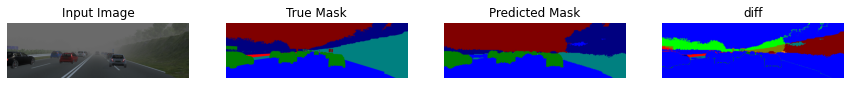

MSE: 8.553778303802062
IOU: [0.845376650405544, 0.4691860580846786, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0022038567493112946, 0.37803682512521614, 1.0, 0.7287216353973311, 1.0, 1.0, 0.8779109667383447, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 20 21]


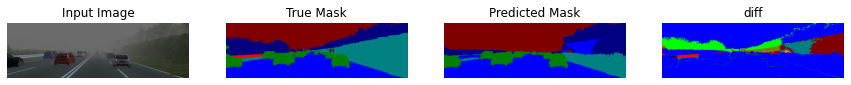

MSE: 11.842721138976959
IOU: [0.8460401546443879, 0.3533297384739822, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4080088987764182, 0.36736171323226113, 1.0, 0.7117925856980147, 1.0, 1.0, 0.9007678257939815, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 20 21]


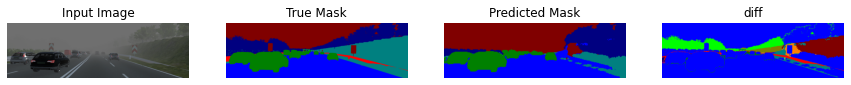

MSE: 11.0843714633746
IOU: [0.8073469697544685, 0.3684555862256211, 0.0, 1.0, 1.0, 1.0, 1.0, 0.36886993603411516, 0.38626683185776683, 1.0, 0.7125989336383595, 1.0, 1.0, 0.9165180283051892, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 20 21]


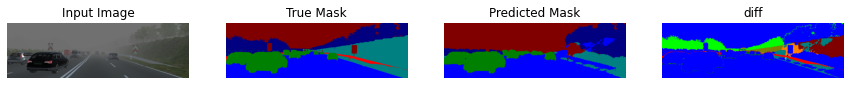

MSE: 11.406760515926154
IOU: [0.7992453062196913, 0.3448562387597605, 0.0, 1.0, 1.0, 1.0, 1.0, 0.4018198738496536, 0.3769872867329319, 1.0, 0.7117217310090999, 1.0, 1.0, 0.9302258988227807, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
fog
[ 0  1  2  7  8 10 13 21]
[ 0  1  7  8 10 13]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 20 21]


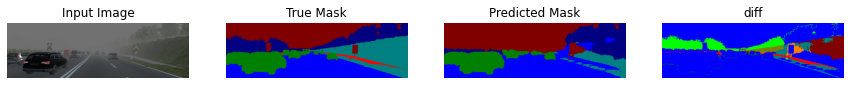

In [35]:
show_predictions_weather(dataset=weather_ds)

In [ ]:
show_metrics_extended(test_ds,num_classes=22, model=model, output_dir='./content/evaluation/model_extended', diff_images_dir='./content/evaluation/model_extended_segmentations')

In [ ]:
show_metrics_extended_weather(weather_ds,num_classes=22, model=model, output_dir='./content/evaluation/model_extended_weather', diff_images_dir='./content/evaluation/model_extended_weather_segmentations',has_weather=True)